# Weekend Movie Trip

a project for EECS 731 by Benjamin Wyss

Examining MovieLens movie data to build a clustering model which can recommend movies similar to other movies

###### python imports

In [4]:
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
plt.close('all')
import warnings
warnings.filterwarnings('ignore')

### Reading Data Sets From CSV

MovieLens Small Datasets - Movies, Ratings, and Tags

Taken from: https://grouplens.org/datasets/movielens/ on 9/23/20

The small data sets were selected because they will reduce overall model complexity while still providing a sufficiently large number of samples (9742 movie samples)


###### Movies and Genres Data Set

In [74]:
movies = pd.read_csv('../data/raw/movies.csv')

In [75]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


###### User Ratings of Movies Data Set

In [76]:
ratings = pd.read_csv('../data/raw/ratings.csv')

In [77]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


###### User Tags of Movies Data Set

In [78]:
tags = pd.read_csv('../data/raw/tags.csv')

In [79]:
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


## The Big Ideas

Feature engineering and transformation can add value to these data sets for building a clustering model in the following ways:

(1): By extracting movie release years from movie titles and binning these years by decade, movies can be clustered together by similar time periods.

(2): By calculating the average user rating per movie, movies can be clustered according to similar ratings.

(3): By encoding a normalized count of the most popular user tags per movie, movies can be clustered according to similar combinations of user tags.

(4): By splitting the movie genres column into multiple columns corresponding to each genre, movies can be clustered according to similar combinations of genres.

## Exploratory Data Analysis

### Cleaning the data sets

In the ratings and tags data sets, the timestamp column is removed because it is related to the time at which users post reviews, not the movies that they review. Hence, this information will not aid the target clustering model.

Additionally, the userId column is dropped from the ratings and tags data sets because I will not be performing any per-user analysis. Rather, the target model will use average data across all users that will be calculated during data set transformation.

Moreover, in the movies and tags data sets, the tag and genres colums are converted to all lowercase letters. This will aid the encoding process because it will ensure that a tag like "heroic bloodshed" is counted the same as "Heroic Bloodshed". The same benefit applies to movie genres as well.

In [80]:
ratings = ratings[['movieId', 'rating']]

In [81]:
ratings

,movieId,rating
0,1,4.0
1,3,4.0
2,6,4.0
3,47,5.0
4,50,5.0
...,...,...
100831,166534,4.0
100832,168248,5.0
100833,168250,5.0
100834,168252,5.0


In [82]:
tags = tags[['movieId', 'tag']]
tags['tag'] = tags['tag'].str.lower()

In [83]:
tags

,movieId,tag
0,60756,funny
1,60756,highly quotable
2,60756,will ferrell
3,89774,boxing story
4,89774,mma
...,...,...
3678,7382,for katie
3679,7936,austere
3680,3265,gun fu
3681,3265,heroic bloodshed


In [84]:
movies['genres'] = movies['genres'].str.lower()

In [85]:
movies

,movieId,title,genres
0,1,Toy Story (1995),adventure|animation|children|comedy|fantasy
1,2,Jumanji (1995),adventure|children|fantasy
2,3,Grumpier Old Men (1995),comedy|romance
3,4,Waiting to Exhale (1995),comedy|drama|romance
4,5,Father of the Bride Part II (1995),comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),action|animation|comedy|fantasy
9738,193583,No Game No Life: Zero (2017),animation|comedy|fantasy
9739,193585,Flint (2017),drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),action|animation


### Transforming the data sets


#### Extracting Release Year From Movie Title

Some movies have an extra space at the end of their title, which causes the year extraction slicing to grab the incorrect string slice. Other movies do not have a year listed, so I looked up and recorded their release year. These movies' years are updated manually so that the year column may be converted to an integer type

In [86]:
movies['year'] = movies['title'].str[-5:-1]

movies.loc[movies.year == '973)', 'year'] = '1973'
movies.loc[movies.year == '995)', 'year'] = '1995'
movies.loc[movies.year == '998)', 'year'] = '1998'
movies.loc[movies.year == '999)', 'year'] = '1999'
movies.loc[movies.year == '008)', 'year'] = '2008'
movies.loc[movies.year == '007)', 'year'] = '2007'
movies.loc[movies.year == '011)', 'year'] = '2011'
movies.loc[movies.year == '012)', 'year'] = '2012'
movies.loc[movies.year == '014)', 'year'] = '2014'

movies.loc[movies.year == 'lon ', 'year'] = '2007'
movies.loc[movies.year == 'r On', 'year'] = '2018'
movies.loc[movies.year == ' Roa', 'year'] = '2015'
movies.loc[movies.year == 'atso', 'year'] = '1980'
movies.loc[movies.year == 'imal', 'year'] = '2016'
movies.loc[movies.year == 'erso', 'year'] = '2016'
movies.loc[movies.year == 'ligh', 'year'] = '2016'
movies.loc[movies.year == 'he O', 'year'] = '2016'
movies.loc[movies.year == 'osmo', 'year'] = '2014'
movies.loc[movies.year == ' Bab', 'year'] = '2017'
movies.loc[movies.year == 'ron ', 'year'] = '2017'
movies.loc[movies.year == 'irro', 'year'] = '2011'

movies['year'] = movies['year'].astype('int32')


In [87]:
movies

,movieId,title,genres,year
0,1,Toy Story (1995),adventure|animation|children|comedy|fantasy,1995
1,2,Jumanji (1995),adventure|children|fantasy,1995
2,3,Grumpier Old Men (1995),comedy|romance,1995
3,4,Waiting to Exhale (1995),comedy|drama|romance,1995
4,5,Father of the Bride Part II (1995),comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),action|animation|comedy|fantasy,2017
9738,193583,No Game No Life: Zero (2017),animation|comedy|fantasy,2017
9739,193585,Flint (2017),drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),action|animation,2018


###### Binning Movie Years by Decade

The movies data set has movies with release years ranging from 1902 to 2018. Hence, I will create bins which represent decades from the 1900s through the 2010s. Labels are selected so that a linear decade scale is created from 0 to 11, where 0 represents the 1900s and 11 represents the 2010s.

Additionally, once the decade bins have been determined, the year column is dropped from the data set so that the target classification model only sees the binned representation of the movie release year. This will aid the classification model because the binned data is more closely grouped together than the non-binned data.

In [88]:
bins = [1899, 1909, 1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009, 2019]
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
movies['decade'] = pd.cut(movies['year'], bins, labels=labels)
years = movies.pop('year')

In [89]:
movies

,movieId,title,genres,decade
0,1,Toy Story (1995),adventure|animation|children|comedy|fantasy,9
1,2,Jumanji (1995),adventure|children|fantasy,9
2,3,Grumpier Old Men (1995),comedy|romance,9
3,4,Waiting to Exhale (1995),comedy|drama|romance,9
4,5,Father of the Bride Part II (1995),comedy,9
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),action|animation|comedy|fantasy,11
9738,193583,No Game No Life: Zero (2017),animation|comedy|fantasy,11
9739,193585,Flint (2017),drama,11
9740,193587,Bungo Stray Dogs: Dead Apple (2018),action|animation,11


#### Calculating Average User Rating per Movie

Some movies have no user review data. These movies' average ratings are replaced with the mean value of all average ratings so that the target clustering model can reason about these movies as if they did have an average user rating.

In [90]:
for i in movies['movieId']:
    movies.loc[movies.movieId == i, 'averageRating'] = ratings[ratings.movieId == i].rating.mean()

In [91]:
movies

,movieId,title,genres,decade,averageRating
0,1,Toy Story (1995),adventure|animation|children|comedy|fantasy,9,3.920930
1,2,Jumanji (1995),adventure|children|fantasy,9,3.431818
2,3,Grumpier Old Men (1995),comedy|romance,9,3.259615
3,4,Waiting to Exhale (1995),comedy|drama|romance,9,2.357143
4,5,Father of the Bride Part II (1995),comedy,9,3.071429
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),action|animation|comedy|fantasy,11,4.000000
9738,193583,No Game No Life: Zero (2017),animation|comedy|fantasy,11,3.500000
9739,193585,Flint (2017),drama,11,3.500000
9740,193587,Bungo Stray Dogs: Dead Apple (2018),action|animation,11,3.500000


#### Calculating Most Popular User Tags per Movie

First, all listed movie tags are extracted from the tags data set, and then these tags are reduced to the list of tags that occur at least 5 times (184 tags meet this requirement). This will reduce the overall complexity of the target clustering model by reducing the total number of input features, and it will also aid the model because the model will not gain much value from clustering according to tags that occur very rarely.

In [92]:
allTags = tags['tag'].value_counts().head(184)

In [93]:
allTags

in netflix queue     131
atmospheric           41
thought-provoking     24
surreal               24
funny                 24
                    ... 
homeless               5
existentialism         5
space opera            5
thriller               5
good dialogue          5
Name: tag, Length: 184, dtype: int64

###### Converting Most Popular User Tags into Movie Attributes

Also, the total count of tags per movie is tracked so that tag counts can be later normalized

In [94]:
movies['totalTags'] = 0
for tag, count in allTags.items():
    for i in movies['movieId']:
        movies.loc[movies.movieId == i, ('tag_' + tag)] = ((tags.movieId == i) & (tags.tag == tag)).sum()
        movies.loc[movies.movieId == i, 'totalTags'] += movies.loc[movies.movieId == i, ('tag_' + tag)]

In [95]:
movies

,movieId,title,genres,decade,averageRating,totalTags,tag_in netflix queue,tag_atmospheric,tag_thought-provoking,tag_surreal,...,tag_sports,tag_ben stiller,tag_epic,tag_president,tag_brad pitt,tag_homeless,tag_existentialism,tag_space opera,tag_thriller,tag_good dialogue
0,1,Toy Story (1995),adventure|animation|children|comedy|fantasy,9,3.920930,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),adventure|children|fantasy,9,3.431818,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),comedy|romance,9,3.259615,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),comedy|drama|romance,9,2.357143,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),comedy,9,3.071429,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),action|animation|comedy|fantasy,11,4.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9738,193583,No Game No Life: Zero (2017),animation|comedy|fantasy,11,3.500000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9739,193585,Flint (2017),drama,11,3.500000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),action|animation,11,3.500000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###### Normalizing Most Popular User Tags per Movie

Each movie's tag attributes are transformed to a value ranging from 0 to 1 which corresponds to the tag's percentage of the total tags for that movie. This normalization will allow movies that have only a few user tags to be compared with movies that have many user tags on a normalized scale. This will aid the target clustering model because it will reduce the variance in numbers of tags per movie.

To avoid dividing by 0, tags are normalized only when a movie has totalTags greater than 0. For a movie with no tags, each tag simply remains at the value 0, which represents no tags being associated with the movie.

Once all normalizations of tags are calculated, the totalTags column is dropped because it will not provide extra value to the target clustering model. This is because the model should not group movies based on how many tags they have, but rather what distribution of tags they have.

In [105]:
tagCols = [col for col in movies.columns if 'tag_' in col]
for col in tagCols:
    for i in movies['movieId']:
        if movies.loc[movies.movieId == i, 'totalTags'].all() != 0:
            movies.loc[movies.movieId == i, col] /= movies.loc[movies.movieId == i, 'totalTags']
totalTags = movies.pop('totalTags')

In [106]:
movies

,movieId,title,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_thought-provoking,tag_surreal,tag_funny,tag_superhero,...,genre_children,genre_animation,genre_mystery,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed)
0,1,Toy Story (1995),9,3.920930,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),9,3.431818,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),9,3.259615,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),9,2.357143,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),9,3.071429,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),11,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),11,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),11,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),11,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0


#### Column Splitting Movie Genres

In the movies data set, the genres column is split into multiple columns to obtain a numerical representation of each movie's genres. Additionally, column splitting ensures that each genre is treated as an independent attribute, which should aid the target clustering model in distinguishing between genre combinations.

###### Calculating All Recorded Movie Genres

In [109]:
allGenres = movies['genres'].str.split('|', expand=True).stack().value_counts()

In [110]:
allGenres

drama                 4361
comedy                3756
thriller              1894
action                1828
romance               1596
adventure             1263
crime                 1199
sci-fi                 980
horror                 978
fantasy                779
children               664
animation              611
mystery                573
documentary            440
war                    382
musical                334
western                167
imax                   158
film-noir               87
(no genres listed)      34
dtype: int64

###### Creating Columns for Each Genre and Splitting the Column

Once the genres have been split into multiple columns, the original genres column is dropped because the target clustering model will not gain any additional value from the strictly textual representation of this data

In [111]:
for genre, count in allGenres.items():
    movies['genre_' + genre] = movies['genres'].str.count(genre)
    
genres = movies.pop('genres')

In [112]:
movies

,movieId,title,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_thought-provoking,tag_surreal,tag_funny,tag_superhero,...,genre_children,genre_animation,genre_mystery,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed)
0,1,Toy Story (1995),9,3.920930,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),9,3.431818,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),9,3.259615,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),9,2.357143,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),9,3.071429,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),11,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),11,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),11,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),11,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0


### Exporting Processed Data Set to CSV File

In [113]:
movies.to_csv('../data/processed/movies_transformed.csv')

### Visualizing the Data

First, the processed data set is read in from its csv file. Some of the data transformation operations applied above are costly to run, and this ensures that those costly operations do not have to be run again as I create visualizations and models in this notebook. When reading in from the csv file, there is an extra Unnamed column which indicates row number. This column is not supposed to be in the data set and is thus dropped.

Next, some basic statistics of the data set and correlation coefficients are calculated

In [12]:
df = pd.read_csv('../data/processed/movies_transformed.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [13]:
df

,movieId,title,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_thought-provoking,tag_surreal,tag_funny,tag_superhero,...,genre_children,genre_animation,genre_mystery,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed)
0,1,Toy Story (1995),9,3.920930,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),9,3.431818,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),9,3.259615,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),9,2.357143,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),9,3.071429,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),11,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),11,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),11,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),11,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0


In [14]:
df.describe()

,movieId,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_thought-provoking,tag_surreal,tag_funny,tag_superhero,tag_sci-fi,...,genre_children,genre_animation,genre_mystery,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed)
count,9742.000000,9742.000000,9724.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,...,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000
mean,42200.353623,9.009546,3.262448,0.012381,0.000740,0.000153,0.000460,0.000596,0.001216,0.000325,...,0.068158,0.062718,0.058817,0.045165,0.039212,0.034285,0.017142,0.016218,0.008930,0.003490
std,52160.494854,1.873478,0.869874,0.109659,0.023327,0.004979,0.018263,0.019243,0.032749,0.014943,...,0.252031,0.242468,0.235295,0.207677,0.194108,0.181968,0.129808,0.126321,0.094083,0.058976
min,1.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3248.250000,8.000000,2.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7300.000000,9.000000,3.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,76232.000000,10.000000,3.911765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,193609.000000,11.000000,5.000000,1.000000,1.000000,0.250000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
df.corr()

,movieId,decade,averageRating,tag_in netflix queue,tag_atmospheric,tag_thought-provoking,tag_surreal,tag_funny,tag_superhero,tag_sci-fi,...,genre_children,genre_animation,genre_mystery,genre_documentary,genre_war,genre_musical,genre_western,genre_imax,genre_film-noir,genre_(no genres listed)
movieId,1.000000,0.483539,0.027841,-0.069708,0.010802,0.017419,0.020990,0.028556,-0.017155,-0.004324,...,0.014081,0.165465,-0.011663,0.063766,-0.048694,-0.069510,-0.033304,0.083922,-0.050462,0.130199
decade,0.483539,1.000000,-0.108485,-0.086768,0.008208,0.009441,0.013226,0.021844,-0.000204,0.009707,...,-0.009640,0.054502,-0.010356,0.087546,-0.087130,-0.143996,-0.095230,0.108659,-0.151914,0.033147
averageRating,0.027841,-0.108485,1.000000,0.074716,0.016156,0.015182,0.024339,0.016441,-0.005590,0.011423,...,-0.048166,0.069797,0.019538,0.129644,0.071785,0.007344,0.018380,0.007321,0.044050,0.007402
tag_in netflix queue,-0.069708,-0.086768,0.074716,1.000000,-0.003572,-0.003475,-0.002835,-0.003498,-0.004192,-0.002458,...,-0.023108,-0.012799,-0.007925,0.037425,0.006127,0.004448,0.006724,-0.007087,0.039034,-0.006682
tag_atmospheric,0.010802,0.008208,0.016156,-0.003572,1.000000,0.005986,0.001561,-0.000089,-0.000748,-0.000629,...,-0.004215,0.015616,0.057715,-0.006900,-0.003890,-0.005978,0.001696,-0.004073,-0.000088,-0.001877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
genre_musical,-0.069510,-0.143996,0.007344,0.004448,-0.005978,-0.005799,-0.004751,-0.005837,-0.006996,-0.004102,...,0.137072,0.111804,-0.035114,-0.005664,-0.032252,1.000000,0.018577,0.011536,-0.017886,-0.011151
genre_western,-0.033304,-0.095230,0.018380,0.006724,0.001696,-0.004065,-0.003330,-0.002950,-0.004904,-0.002875,...,-0.016890,-0.024378,-0.019570,-0.024915,0.014063,0.018577,1.000000,-0.004436,-0.004130,-0.007816
genre_imax,0.083922,0.108659,0.007321,-0.007087,-0.004073,0.010691,0.001808,-0.003978,0.030560,0.008635,...,0.062011,0.080744,-0.011374,0.003381,-0.009192,0.011536,-0.004436,1.000000,-0.012188,-0.007599
genre_film-noir,-0.050462,-0.151914,0.044050,0.039034,-0.000088,-0.002922,-0.002394,-0.002941,-0.003525,-0.002067,...,-0.025673,-0.015555,0.087567,-0.020645,-0.019177,-0.017886,-0.004130,-0.012188,1.000000,-0.005618


###### Generating Interesting Plots

<AxesSubplot:title={'center':'Histogram of Average Movie Ratings'}, ylabel='Frequency'>

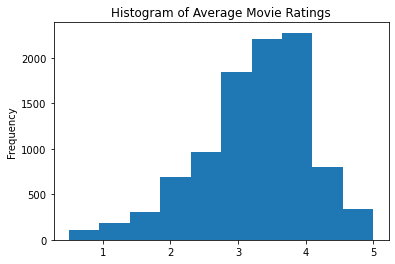

In [30]:
df['averageRating'].plot.hist(title='Histogram of Average Movie Ratings')

<AxesSubplot:title={'center':'Average Movie Rating vs Movie Decade'}, xlabel='decade', ylabel='averageRating'>

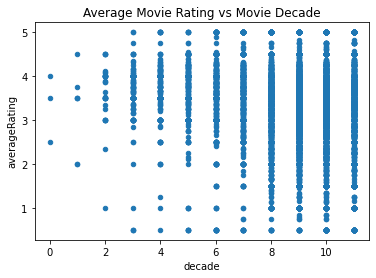

In [18]:
df.plot.scatter(x='decade', y='averageRating', title='Average Movie Rating vs. Movie Decade')

<AxesSubplot:title={'center':"Average Movie Rating vs. Movies Tagged in a User's Netflix Queue"}, xlabel='tag_in netflix queue', ylabel='averageRating'>

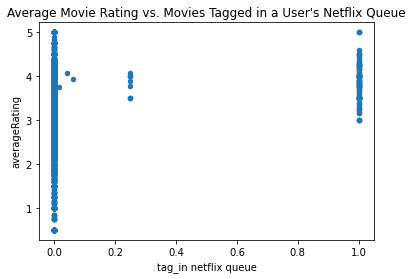

In [20]:
df.plot.scatter(x='tag_in netflix queue', y='averageRating', title='Average Movie Rating vs. Movies Tagged in a User\'s Netflix Queue')

<AxesSubplot:title={'center':'Average Movie Rating vs. Movies Listed in Documentary Genre'}, xlabel='genre_documentary', ylabel='averageRating'>

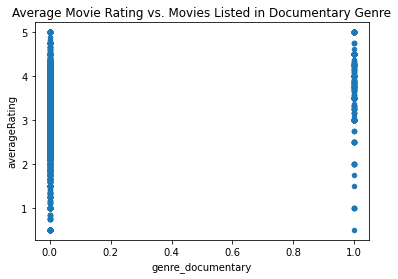

In [25]:
df.plot.scatter(x='genre_documentary', y='averageRating', title='Average Movie Rating vs. Movies Listed in Documentary Genre')

###### Intuitions Gained From Visualizations

It appears that many of the features in this dataset show some level of correlation. The target clustering model should be designed to account for dependencies of features.

### Model Construction


### Results
